The goal of this notebook is to test the capability of an MLP to match some data.

1. First, a grid where 50% of the points are 0 and 50% are 1
2. Second, the same grid where 95% of the points are 0 and 5% are 1
3. Third, a sin(x) * sin(y) function

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
nelem_x = 50
nelem_y = 50

In [4]:
x = np.linspace(0,1,nelem_x)
y = np.linspace(0,1,nelem_y)

xx, yy = np.meshgrid(x,y)

In [5]:
df_data = pd.DataFrame()
df_data['X'] = xx.reshape(-1)
df_data['Y'] = yy.reshape(-1)

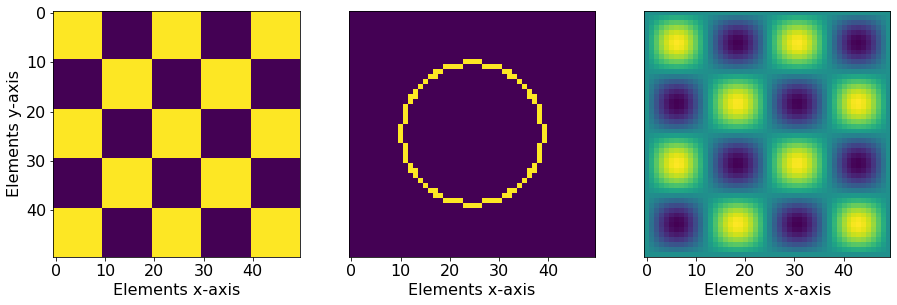

In [6]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
mask = np.zeros((nelem_x,nelem_y))
for i in range(0,nelem_x,20):
        for j in range(0,nelem_x,20):
            mask[i:i+10,j:j+10] = 1
            mask[i+10:i+20,j+10:j+20] = 1

ax[0].imshow(mask)
ax[0].set_xlabel('Elements x-axis',fontsize = 16)
ax[0].set_ylabel('Elements y-axis',fontsize = 16)
ax[0].tick_params(axis='both', labelsize=16)

mask = np.zeros((nelem_x,nelem_y))
mask[np.sqrt((xx - 0.5) ** 2 + (yy - 0.5) ** 2) < 0.3] = 1
mask[np.sqrt((xx - 0.5) ** 2 + (yy - 0.5) ** 2) < 0.28] = 0
ax[1].imshow(mask)
ax[1].set_yticks([])
ax[1].set_xlabel('Elements x-axis',fontsize = 16)
ax[1].tick_params(axis='x', labelsize=16)

ax[2].imshow(np.sin(4*np.pi*xx)*np.sin(4*np.pi*yy))
ax[2].set_yticks([])
ax[2].set_xlabel('Elements x-axis',fontsize = 16)
ax[2].tick_params(axis='x', labelsize=16)
plt.savefig('Dummy_Data.png',dpi=600,bbox_inches='tight')

In [37]:
mask = np.zeros((nelem_x,nelem_y))
for i in range(0,nelem_x,20):
        for j in range(0,nelem_x,20):
            mask[i:i+10,j:j+10] = 1
            mask[i+10:i+20,j+10:j+20] = 1

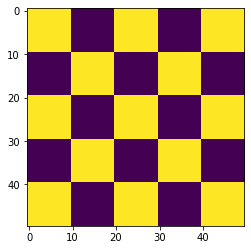

In [38]:
plt.imshow(mask)

In [39]:
df_data['P_10'] = mask.reshape(-1)

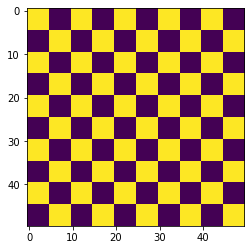

In [40]:
mask = np.zeros((nelem_x,nelem_y))

for i in range(0,nelem_x,10):
        for j in range(0,nelem_x,10):
            mask[i:i+5,j:j+5] = 1
            mask[i+5:i+10,j+5:j+10] = 1

plt.imshow(mask)

In [41]:
df_data['P_5'] = mask.reshape(-1)

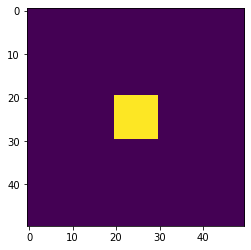

In [43]:
mask = np.zeros((nelem_x,nelem_y))

mask[20:30,20:30] = 1

plt.imshow(mask)

In [44]:
df_data['Sq'] = mask.reshape(-1)

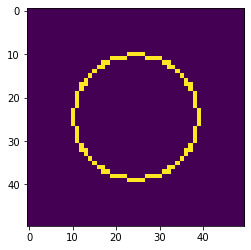

In [45]:
mask = np.zeros((nelem_x,nelem_y))

mask[np.sqrt((xx - 0.5) ** 2 + (yy - 0.5) ** 2) < 0.3] = 1

mask[np.sqrt((xx - 0.5) ** 2 + (yy - 0.5) ** 2) < 0.28] = 0

plt.imshow(mask)

In [46]:
df_data['Circ'] = mask.reshape(-1)

In [47]:
df_data['SinSin'] = (np.sin(4*np.pi*xx)*np.sin(4*np.pi*yy)).reshape(-1)

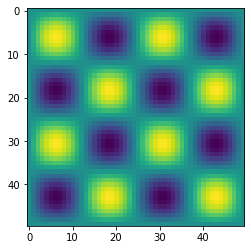

In [48]:
plt.imshow(np.sin(4*np.pi*xx)*np.sin(4*np.pi*yy))

In [49]:
# Analyse the proportions
print('### Size 5 ###')
for i in range(2):
    print("Label : {}, Number : {}".format(df_data['P_5'].value_counts().index[i],df_data['P_5'].value_counts().values[i]))

print('### Size 10 ###')
for i in range(2):
    print("Label : {}, Number : {}".format(df_data['P_10'].value_counts().index[i],df_data['P_10'].value_counts().values[i]))

print('### Square ###')
for i in range(2):
    print("Label : {}, Number : {}".format(df_data['Sq'].value_counts().index[i],df_data['Sq'].value_counts().values[i]))

print('### Circle ###')
for i in range(2):
    print("Label : {}, Number : {}".format(df_data['Circ'].value_counts().index[i],df_data['Circ'].value_counts().values[i]))

### Size 5 ###
Label : 0.0, Number : 1250
Label : 1.0, Number : 1250
### Size 10 ###
Label : 1.0, Number : 1300
Label : 0.0, Number : 1200
### Square ###
Label : 0.0, Number : 2400
Label : 1.0, Number : 100
### Circle ###
Label : 0.0, Number : 2412
Label : 1.0, Number : 88


In [50]:
import torch
import torch.nn as nn

In [51]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [52]:
class Model(nn.Module):
    def __init__(self,
                in_size = 2, 
                neurons_layer=[100, 100],
                out_size = 1
                ):
        """
        Initializing the PINN
        """
        nn.Module.__init__(self)

        self.layers = nn.ModuleList()

        # first layer
        self.layers.append(nn.Linear(in_features=in_size, out_features=neurons_layer[0])) 

        # hidden layers
        for n_in, n_out in zip(neurons_layer[:-1], neurons_layer[1:]):
            self.layers.append(nn.Linear(in_features=n_in, out_features=n_out))

        # output layer
        self.out  = nn.Linear(in_features=neurons_layer[-1], out_features=out_size)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward Pass
        """
        for linear in self.layers:
            x = self.relu(linear(x))
        x = self.out(x)
        return x

In [53]:
def train(model,X_train,y_train,loss_fn,optimizer,epoch,device='cuda:0'):

    print(device)
    model = model.to(device)

    x = torch.tensor(X_train[:, 0:1], requires_grad=True).float().to(device)
    y = torch.tensor(X_train[:, 1:2], requires_grad=True).float().to(device)

    true = torch.tensor(y_train).float().to(device)

    tot_loss = []
    for i in range(epoch):
        model.train()

        optimizer.zero_grad()

        preds = model(torch.cat([x, y], dim=1))

        loss = loss_fn(preds,true)
        loss.backward()
        optimizer.step()

        if i % 2000 == 0:
            print('Iter %d, Loss: %.5e' % (i,loss))

        tot_loss.append(loss)

    model.eval()

    preds = model(torch.cat([x, y], dim=1))
    preds = preds.detach().cpu().numpy()

    return model, preds, tot_loss

In [54]:
def plots(preds,true,name):
    # Compute error :
    error = preds-true

    # Plot :
    fig, ax = plt.subplots(1,3,figsize=(16,4))

    im = ax[0].imshow(preds.reshape(50,50))
    ax[0].set_title('Prediction',fontsize = 16)
    cb = plt.colorbar(im, ax=ax[0])
    cb.ax.tick_params(labelsize=16)
    ax[0].set_xlabel('Elements x-axis',fontsize = 16)
    ax[0].set_ylabel('Elements y-axis',fontsize = 16)
    ax[0].tick_params(axis='both', labelsize=16)

    im = ax[1].imshow(true.reshape(50,50))
    ax[1].set_title('True',fontsize = 16)
    cb = plt.colorbar(im, ax=ax[1])
    cb.ax.tick_params(labelsize=16)
    ax[1].set_yticks([])
    ax[1].set_xlabel('Elements x-axis',fontsize = 16)
    ax[1].tick_params(axis='x', labelsize=16)

    im = ax[2].imshow(error.reshape(50,50))
    ax[2].set_title('Error',fontsize = 16)
    cb = plt.colorbar(im, ax=ax[2])
    cb.ax.tick_params(labelsize=16)
    ax[2].set_yticks([])
    ax[2].set_xlabel('Elements x-axis',fontsize = 16)
    ax[2].tick_params(axis='x', labelsize=16)
    plt.savefig(name,dpi=600,bbox_inches='tight')
    plt.show()

In [55]:
model = Model()

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

X_train = df_data.loc[:,['X','Y']].values
y_train = df_data.loc[:,['P_10']].values

epoch = 100000
model_trained_10, preds_10, loss_10 = train(model,X_train,y_train,loss_fn,optimizer,epoch)

cuda:0
Iter 0, Loss: 3.49764e-01
Iter 2000, Loss: 6.50801e-02
Iter 4000, Loss: 5.56477e-02
Iter 6000, Loss: 5.11175e-02
Iter 8000, Loss: 4.74842e-02
Iter 10000, Loss: 4.48714e-02
Iter 12000, Loss: 4.26923e-02
Iter 14000, Loss: 4.07034e-02
Iter 16000, Loss: 3.86849e-02
Iter 18000, Loss: 3.73358e-02
Iter 20000, Loss: 3.70436e-02
Iter 22000, Loss: 3.58370e-02
Iter 24000, Loss: 3.54477e-02
Iter 26000, Loss: 3.45668e-02
Iter 28000, Loss: 3.37631e-02
Iter 30000, Loss: 3.38076e-02
Iter 32000, Loss: 3.36225e-02
Iter 34000, Loss: 3.30519e-02
Iter 36000, Loss: 3.21746e-02
Iter 38000, Loss: 3.23159e-02
Iter 40000, Loss: 3.09018e-02
Iter 42000, Loss: 3.04686e-02
Iter 44000, Loss: 3.01509e-02
Iter 46000, Loss: 2.99455e-02
Iter 48000, Loss: 3.03365e-02
Iter 50000, Loss: 2.97729e-02
Iter 52000, Loss: 2.94917e-02
Iter 54000, Loss: 2.88439e-02
Iter 56000, Loss: 2.87437e-02
Iter 58000, Loss: 2.75620e-02
Iter 60000, Loss: 2.79900e-02
Iter 62000, Loss: 2.76604e-02
Iter 64000, Loss: 2.74256e-02
Iter 66000,

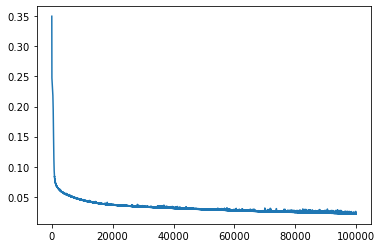

In [56]:
# plot loss
plt.plot(loss_10)

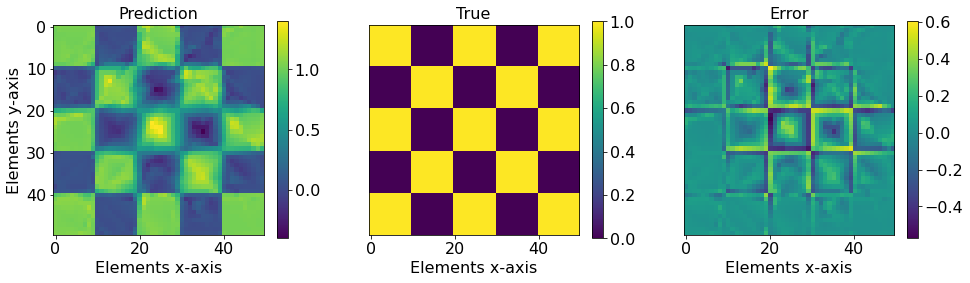

In [57]:
plots(preds_10,y_train,'square_10.png')

In [105]:
model = Model()

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

X_train = df_data.loc[:,['X','Y']].values
y_train = df_data.loc[:,['P_5']].values

epoch = 100000
model_trained_5, preds_5, loss_5 = train(model,X_train,y_train,loss_fn,optimizer,epoch)

Iter 0, Loss: 6.00869e-01
Iter 2000, Loss: 2.32933e-01
Iter 4000, Loss: 1.92535e-01
Iter 6000, Loss: 1.75783e-01
Iter 8000, Loss: 1.66573e-01
Iter 10000, Loss: 1.58822e-01
Iter 12000, Loss: 1.49296e-01
Iter 14000, Loss: 1.44298e-01
Iter 16000, Loss: 1.39535e-01
Iter 18000, Loss: 1.33561e-01
Iter 20000, Loss: 1.33591e-01
Iter 22000, Loss: 1.27024e-01
Iter 24000, Loss: 1.26737e-01
Iter 26000, Loss: 1.22354e-01
Iter 28000, Loss: 1.26327e-01
Iter 30000, Loss: 1.18339e-01
Iter 32000, Loss: 1.16441e-01
Iter 34000, Loss: 1.16353e-01
Iter 36000, Loss: 1.15214e-01
Iter 38000, Loss: 1.12674e-01
Iter 40000, Loss: 1.11626e-01
Iter 42000, Loss: 1.10042e-01
Iter 44000, Loss: 1.07244e-01
Iter 46000, Loss: 1.13842e-01
Iter 48000, Loss: 1.06945e-01
Iter 50000, Loss: 1.04644e-01
Iter 52000, Loss: 1.03610e-01
Iter 54000, Loss: 1.02278e-01
Iter 56000, Loss: 1.01265e-01
Iter 58000, Loss: 9.84631e-02
Iter 60000, Loss: 9.93833e-02
Iter 62000, Loss: 9.60956e-02
Iter 64000, Loss: 9.65430e-02
Iter 66000, Loss: 

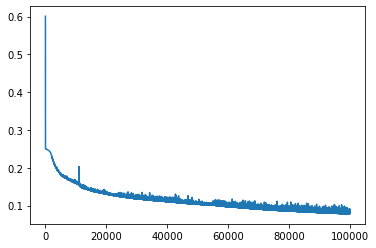

In [106]:
# plot loss
plt.plot(loss_5)

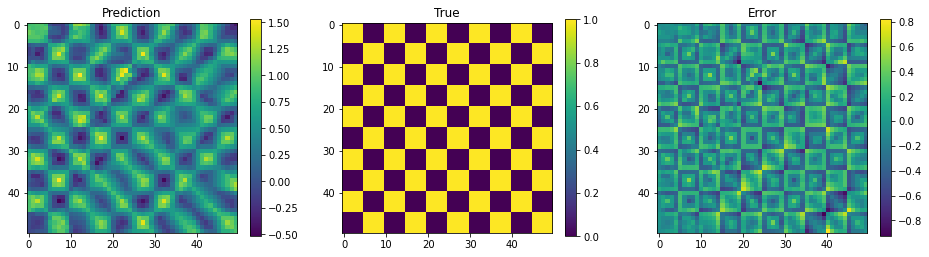

In [107]:
plots(preds_5,y_train)

In [108]:
model = Model()

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

X_train = df_data.loc[:,['X','Y']].values
y_train = df_data.loc[:,['Sq']].values

epoch = 100000
model_trained_Sq, preds_Sq, loss_Sq = train(model,X_train,y_train,loss_fn,optimizer,epoch)

Iter 0, Loss: 4.43822e-02
Iter 2000, Loss: 3.82719e-03
Iter 4000, Loss: 1.84991e-03
Iter 6000, Loss: 5.35936e-04
Iter 8000, Loss: 2.03849e-04
Iter 10000, Loss: 1.10635e-04
Iter 12000, Loss: 3.64636e-04
Iter 14000, Loss: 6.88061e-05
Iter 16000, Loss: 1.14823e-04
Iter 18000, Loss: 3.15331e-04
Iter 20000, Loss: 3.62004e-05
Iter 22000, Loss: 2.95986e-05
Iter 24000, Loss: 2.68208e-05
Iter 26000, Loss: 2.34725e-05
Iter 28000, Loss: 5.84021e-05
Iter 30000, Loss: 4.19905e-05
Iter 32000, Loss: 2.77968e-05
Iter 34000, Loss: 2.62934e-05
Iter 36000, Loss: 4.51088e-04
Iter 38000, Loss: 2.06683e-05
Iter 40000, Loss: 3.14198e-05
Iter 42000, Loss: 3.13437e-05
Iter 44000, Loss: 1.31013e-05
Iter 46000, Loss: 1.20543e-05
Iter 48000, Loss: 5.46237e-05
Iter 50000, Loss: 1.00700e-04
Iter 52000, Loss: 9.34836e-06
Iter 54000, Loss: 5.95782e-05
Iter 56000, Loss: 2.04075e-05
Iter 58000, Loss: 9.79598e-05
Iter 60000, Loss: 2.12639e-04
Iter 62000, Loss: 3.60433e-05
Iter 64000, Loss: 1.86370e-05
Iter 66000, Loss: 

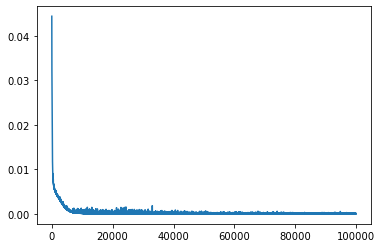

In [109]:
# plot loss
plt.plot(loss_Sq)

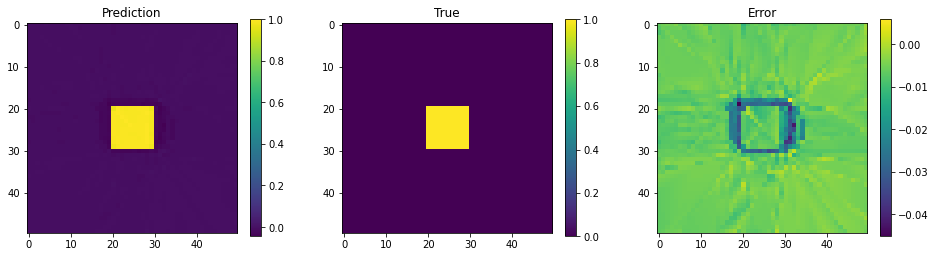

In [110]:
plots(preds_Sq,y_train)

In [111]:
model = Model()

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

X_train = df_data.loc[:,['X','Y']].values
y_train = df_data.loc[:,['Circ']].values

epoch = 100000
model_trained_Circ, preds_Circ, loss_Circ = train(model,X_train,y_train,loss_fn,optimizer,epoch)

Iter 0, Loss: 3.40714e-02
Iter 2000, Loss: 2.32711e-02
Iter 4000, Loss: 2.03330e-02
Iter 6000, Loss: 1.76750e-02
Iter 8000, Loss: 1.63437e-02
Iter 10000, Loss: 1.44728e-02
Iter 12000, Loss: 1.30328e-02
Iter 14000, Loss: 1.19258e-02
Iter 16000, Loss: 1.11320e-02
Iter 18000, Loss: 1.08599e-02
Iter 20000, Loss: 1.01404e-02
Iter 22000, Loss: 9.83960e-03
Iter 24000, Loss: 9.39563e-03
Iter 26000, Loss: 9.61151e-03
Iter 28000, Loss: 8.84691e-03
Iter 30000, Loss: 9.04628e-03
Iter 32000, Loss: 8.54158e-03
Iter 34000, Loss: 9.13840e-03
Iter 36000, Loss: 8.01642e-03
Iter 38000, Loss: 8.45556e-03
Iter 40000, Loss: 7.79379e-03
Iter 42000, Loss: 7.55304e-03
Iter 44000, Loss: 7.54952e-03
Iter 46000, Loss: 7.29745e-03
Iter 48000, Loss: 7.74402e-03
Iter 50000, Loss: 7.35562e-03
Iter 52000, Loss: 7.09333e-03
Iter 54000, Loss: 7.91349e-03
Iter 56000, Loss: 6.67920e-03
Iter 58000, Loss: 7.05833e-03
Iter 60000, Loss: 6.97341e-03
Iter 62000, Loss: 6.38478e-03
Iter 64000, Loss: 6.61359e-03
Iter 66000, Loss: 

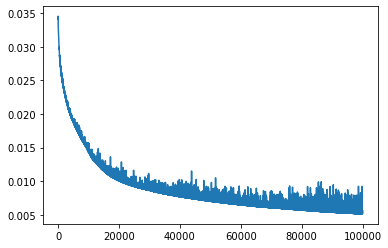

In [112]:
# plot loss
plt.plot(loss_Circ)

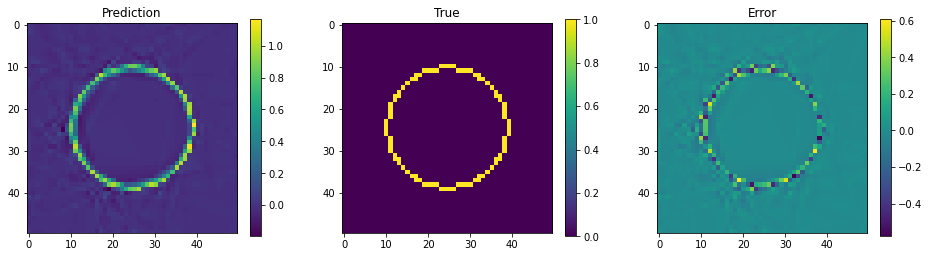

In [113]:
plots(preds_Circ,y_train)

In [58]:
model = Model()

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

X_train = df_data.loc[:,['X','Y']].values
y_train = df_data.loc[:,['SinSin']].values

epoch = 100000
model_trained_SinSin, preds_SinSin, loss_SinSin = train(model,X_train,y_train,loss_fn,optimizer,epoch)

cuda:0
Iter 0, Loss: 2.42598e-01
Iter 2000, Loss: 3.52477e-03
Iter 4000, Loss: 1.33371e-03
Iter 6000, Loss: 8.31813e-04
Iter 8000, Loss: 8.45205e-04
Iter 10000, Loss: 7.87596e-04
Iter 12000, Loss: 4.63296e-04
Iter 14000, Loss: 4.33178e-04
Iter 16000, Loss: 3.79633e-04
Iter 18000, Loss: 3.50614e-04
Iter 20000, Loss: 3.26886e-04
Iter 22000, Loss: 3.09060e-04
Iter 24000, Loss: 2.98264e-04
Iter 26000, Loss: 3.59588e-04
Iter 28000, Loss: 4.93845e-04
Iter 30000, Loss: 2.60522e-04
Iter 32000, Loss: 7.29410e-04
Iter 34000, Loss: 2.44485e-04
Iter 36000, Loss: 2.76219e-04
Iter 38000, Loss: 2.29196e-04
Iter 40000, Loss: 2.73173e-04
Iter 42000, Loss: 2.11758e-04
Iter 44000, Loss: 1.61665e-03
Iter 46000, Loss: 2.03182e-04
Iter 48000, Loss: 1.98844e-04
Iter 50000, Loss: 1.96606e-04
Iter 52000, Loss: 1.93898e-04
Iter 54000, Loss: 2.01402e-04
Iter 56000, Loss: 1.88893e-04
Iter 58000, Loss: 3.04626e-04
Iter 60000, Loss: 1.91797e-04
Iter 62000, Loss: 1.82067e-04
Iter 64000, Loss: 8.31487e-04
Iter 66000,

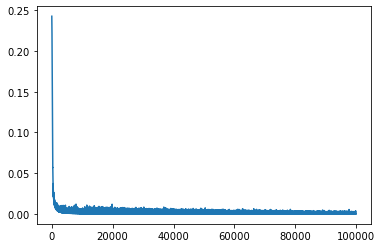

In [59]:
# plot loss
plt.plot(loss_SinSin)

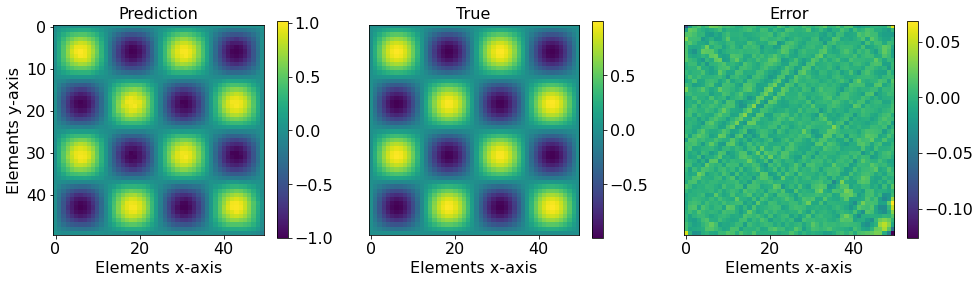

In [60]:
plots(preds_SinSin,y_train,'sinsin_preds.png')